In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the missing resource

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
from bs4 import BeautifulSoup


In [6]:
import nltk
from nltk.corpus import stopwords
#load the stop words
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [10]:
import string

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
df=pd.read_csv('depression_detection.csv')

In [13]:
df

,text,label
0,i'm tired of my life and i'm not sure what to ...,1
1,"33, heartbroken and alone, with no future hope...",1
2,let's see what else i can cram in with two day...,0
3,"day 40, ending it all anyway, nothing happened...",0
4,guys the results are here.. megathiccc is best...,0
...,...,...
119995,fear of growing up. what the fuck do i do?? be...,0
119996,i feel crushingly alone and have no one to tal...,1
119997,texas is a trash state i'm always hearing abou...,0
119998,remember when there where only 3 awards now th...,0


dataset yaha se liya->https://huggingface.co/datasets/thePixel42/depression-detection

i have combined the train and test in one dataset

#training on a small subset only

In [14]:

# Sample 10k from each class
df_small = df.groupby('label').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)

# Shuffle to mix the classes
df_small = df_small.sample(frac=1, random_state=42).reset_index(drop=True)

# Save reduced dataset
df_small.to_csv("balanced_20k.csv", index=False)

C:\Users\Dell\AppData\Local\Temp\ipykernel_20436\2328106766.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby('label').apply(lambda x: x.sample(n=10000, random_state=42)).reset_index(drop=True)


1-> depression
0-> not depression

In [15]:
df_small['label'].value_counts()

label
1    10000
0    10000
Name: count, dtype: int64

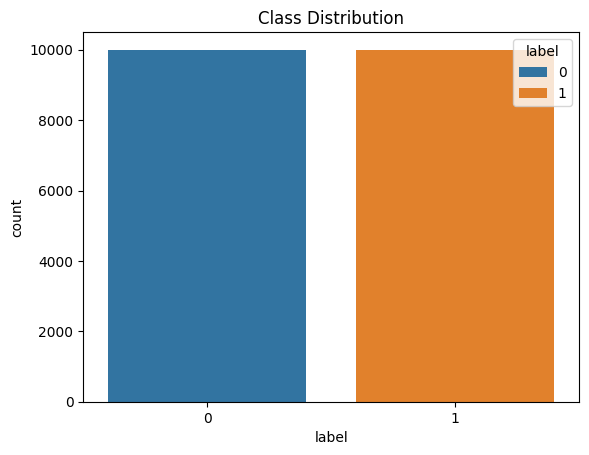

In [16]:
sns.countplot(data=df_small,x='label',hue='label')
plt.title('Class Distribution')
#changing labels from 0,1 to non depression,depression
df_small['label']=df_small['label'].replace({0:'non depression',1:'depression'})

In [17]:
df

,text,label
0,i'm tired of my life and i'm not sure what to ...,1
1,"33, heartbroken and alone, with no future hope...",1
2,let's see what else i can cram in with two day...,0
3,"day 40, ending it all anyway, nothing happened...",0
4,guys the results are here.. megathiccc is best...,0
...,...,...
119995,fear of growing up. what the fuck do i do?? be...,0
119996,i feel crushingly alone and have no one to tal...,1
119997,texas is a trash state i'm always hearing abou...,0
119998,remember when there where only 3 awards now th...,0


In [18]:
df_small

,text,label
0,overdose seroquellexaprowill it fucking kill m...,depression
1,holy shit my eyes reddit light mode is a plagu...,non depression
2,my dad is into some shady shit partialy heard ...,non depression
3,don't read the spolier \&gt;!reply to this pos...,non depression
4,"am i depressed, or just periodically 'down'? i...",depression
...,...,...
19995,i've become a demon.read my previous posts for...,depression
19996,i always end up leaning towards surrealistic w...,depression
19997,so i was gonna post some art...but considering...,non depression
19998,tell me what is your favorite thing you ate to...,non depression


In [19]:
df_small.isnull().sum()

text     0
label    0
dtype: int64

Text Cleaning

1. Text lower casing

In [20]:
def lower(s):
    return s.lower()

In [21]:
df_small['text']=df_small['text'].apply(lower)

2. Removing punctuation

In [22]:
remove=string.punctuation
def remove_punctuation(s):
    return s.translate(str.maketrans('','',remove))

In [23]:
df_small['text']=df_small['text'].apply(remove_punctuation)

C) Removing Digits

In [24]:
def remove_digits(s):
    return s.translate(str.maketrans('','',string.digits))
df_small['text']=df_small['text'].apply(remove_digits)

D) Extra Space removal

In [25]:
def remove_extra_space(text):
    ans = " ".join(text.split())
    return ans

df_small['text']=df_small['text'].apply(remove_extra_space)

E) Stop Words

In [26]:


# Load the English Punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_stop_words(text):
    # Tokenize the text using the loaded tokenizer
    tokens = tokenizer.tokenize(text)

    # Remove stop words
    clean_tokens = [token for token in tokens if token not in stop_words]

    # Join the clean tokens into a single string
    clean_text = ' '.join(clean_tokens)

    return clean_text

df_small['text']=df_small['text'].apply(remove_stop_words)

F) removing html tags

In [27]:
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()
df_small['text']=df_small['text'].apply(remove_html_tags)

G) Removing URLS

In [28]:
def remove_url(text):
  return re.sub(r'https?:\S*', '', text)
df_small['text']=df_small['text'].apply(remove_url)

H) Removing special characters

In [29]:
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    return re.sub(pat, '', text)
df_small['text']=df_small['text'].apply(remove_special_characters)

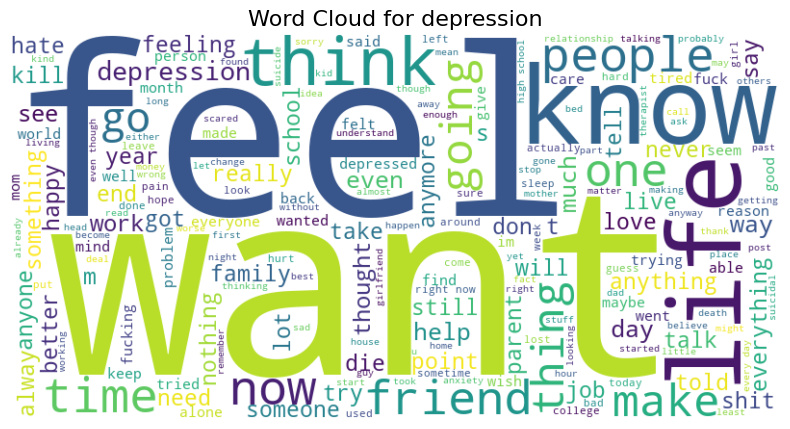

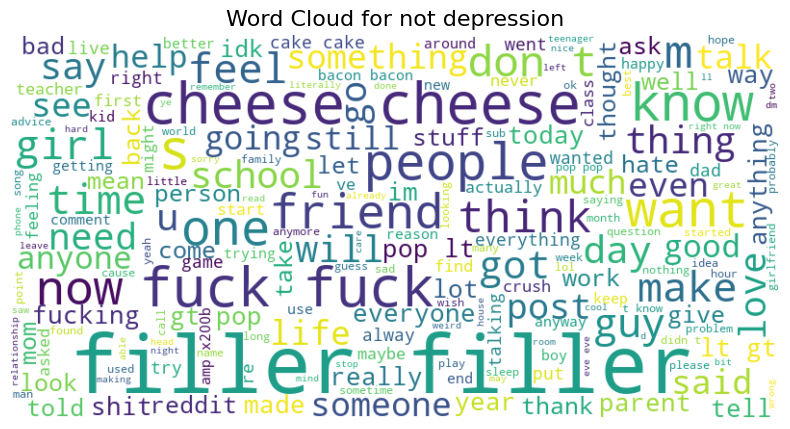

In [30]:


df2 = pd.read_csv('depression_detection.csv')

for label in df2['label'].unique():
    # Combine all text for this status
    class_text = " ".join(df2[df2['label'] == label]['text'])

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color="white").generate(class_text)

    # Plot
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")

    # Title
    plt.title(f"Word Cloud for {'depression' if label == 1 else 'not depression'}", fontsize=16)
    plt.show()


done with text cleaning will now apply BOW and TFIDF with algos

In [31]:
bow=CountVectorizer(max_features=1000)
tfidf=TfidfVectorizer(max_features=1000)

In [32]:
df_small

,text,label
0,overdose seroquellexaprowill it fucking kill m...,depression
1,holy shit my eyes reddit light mode is a plagu...,non depression
2,my dad is into some shady shit partialy heard ...,non depression
3,dont read the spolier gtreply to this post or ...,non depression
4,am i depressed or just periodically down is th...,depression
...,...,...
19995,ive become a demonread my previous posts for d...,depression
19996,i always end up leaning towards surrealistic w...,depression
19997,so i was gonna post some artbut considering th...,non depression
19998,tell me what is your favorite thing you ate to...,non depression


In [33]:
X,Y=df_small['text'],df_small['label']

In [34]:
encoding={'depression':1,
          'non depression':0}

In [35]:
Y = df_small['label'].map(encoding)

In [36]:
Y

0        1
1        0
2        0
3        0
4        1
        ..
19995    1
19996    1
19997    0
19998    0
19999    1
Name: label, Length: 20000, dtype: int64

In [37]:
X

0        overdose seroquellexaprowill it fucking kill m...
1        holy shit my eyes reddit light mode is a plagu...
2        my dad is into some shady shit partialy heard ...
3        dont read the spolier gtreply to this post or ...
4        am i depressed or just periodically down is th...
                               ...                        
19995    ive become a demonread my previous posts for d...
19996    i always end up leaning towards surrealistic w...
19997    so i was gonna post some artbut considering th...
19998    tell me what is your favorite thing you ate to...
19999    im tiredi have bpd and depression im not medic...
Name: text, Length: 20000, dtype: object

training and testing splitting

In [38]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [39]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(16000,)
(16000,)
(4000,)
(4000,)


BOW training

In [40]:
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)

TFIDF training

In [41]:
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)

Ml Models training

BOW All models

1. Logistic Regression

In [42]:
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train_bow,Y_train)
Y_pred_bow_lr=lr.predict(X_test_bow)
print(accuracy_score(Y_test,Y_pred_bow_lr))
print(confusion_matrix(Y_test,Y_pred_bow_lr))
print(classification_report(Y_test,Y_pred_bow_lr))

0.89375
[[1897  158]
 [ 267 1678]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2055
           1       0.91      0.86      0.89      1945

    accuracy                           0.89      4000
   macro avg       0.90      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



2. Support Vector Machines

In [43]:
svm=SVC()
svm.fit(X_train_bow,Y_train)
Y_pred_bow_svm=svm.predict(X_test_bow)
print(accuracy_score(Y_test,Y_pred_bow_svm))
print(confusion_matrix(Y_test,Y_pred_bow_svm))
print(classification_report(Y_test,Y_pred_bow_svm))

0.8685
[[1918  137]
 [ 389 1556]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      2055
           1       0.92      0.80      0.86      1945

    accuracy                           0.87      4000
   macro avg       0.88      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



3. KNN

In [44]:
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_bow,Y_train)
Y_pred_bow_knn=knn.predict(X_test_bow)
print(accuracy_score(Y_test,Y_pred_bow_knn))
print(confusion_matrix(Y_test,Y_pred_bow_knn))
print(classification_report(Y_test,Y_pred_bow_knn))

0.78125
[[1923  132]
 [ 743 1202]]
              precision    recall  f1-score   support

           0       0.72      0.94      0.81      2055
           1       0.90      0.62      0.73      1945

    accuracy                           0.78      4000
   macro avg       0.81      0.78      0.77      4000
weighted avg       0.81      0.78      0.78      4000



4. DT

In [45]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train_bow,Y_train)
Y_pred_bow_dtc=dtc.predict(X_test_bow)
print(accuracy_score(Y_test,Y_pred_bow_dtc))
print(confusion_matrix(Y_test,Y_pred_bow_dtc))
print(classification_report(Y_test,Y_pred_bow_dtc))

0.82925
[[1709  346]
 [ 337 1608]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      2055
           1       0.82      0.83      0.82      1945

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



5.RFC

In [46]:
rfc=RandomForestClassifier()
rfc.fit(X_train_bow,Y_train)
Y_pred_bow_rfc=rfc.predict(X_test_bow)
print(accuracy_score(Y_test,Y_pred_bow_rfc))
print(confusion_matrix(Y_test,Y_pred_bow_rfc))
print(classification_report(Y_test,Y_pred_bow_rfc))

0.88475
[[1798  257]
 [ 204 1741]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2055
           1       0.87      0.90      0.88      1945

    accuracy                           0.88      4000
   macro avg       0.88      0.89      0.88      4000
weighted avg       0.89      0.88      0.88      4000



TF IDF all models

 1.Logistic Regression

In [47]:
lr=LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf,Y_train)
Y_pred_tfidf_lr=lr.predict(X_test_tfidf)
print(accuracy_score(Y_test,Y_pred_tfidf_lr))
print(confusion_matrix(Y_test,Y_pred_tfidf_lr))
print(classification_report(Y_test,Y_pred_tfidf_lr))

0.902
[[1882  173]
 [ 219 1726]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2055
           1       0.91      0.89      0.90      1945

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



2. SVM

In [48]:
svm=SVC()
svm.fit(X_train_tfidf,Y_train)
Y_pred_tfidf_svm=svm.predict(X_test_tfidf)
print(accuracy_score(Y_test,Y_pred_tfidf_svm))
print(confusion_matrix(Y_test,Y_pred_tfidf_svm))
print(classification_report(Y_test,Y_pred_tfidf_svm))

0.91175
[[1903  152]
 [ 201 1744]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2055
           1       0.92      0.90      0.91      1945

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



3.KNN

In [49]:
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_tfidf,Y_train)
Y_pred_tfidf_knn=knn.predict(X_test_tfidf)
print(accuracy_score(Y_test,Y_pred_tfidf_knn))
print(confusion_matrix(Y_test,Y_pred_tfidf_knn))
print(classification_report(Y_test,Y_pred_tfidf_knn))

0.66775
[[1931  124]
 [1205  740]]
              precision    recall  f1-score   support

           0       0.62      0.94      0.74      2055
           1       0.86      0.38      0.53      1945

    accuracy                           0.67      4000
   macro avg       0.74      0.66      0.64      4000
weighted avg       0.73      0.67      0.64      4000



4.DT

In [50]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train_tfidf,Y_train)
Y_pred_tfidf_dtc=dtc.predict(X_test_tfidf)
print(accuracy_score(Y_test,Y_pred_tfidf_dtc))
print(confusion_matrix(Y_test,Y_pred_tfidf_dtc))
print(classification_report(Y_test,Y_pred_tfidf_dtc))

0.831
[[1717  338]
 [ 338 1607]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2055
           1       0.83      0.83      0.83      1945

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



5.RFC

In [51]:
rfc=RandomForestClassifier()
rfc.fit(X_train_tfidf,Y_train)
Y_pred_tfidf_rfc=rfc.predict(X_test_tfidf)
print(accuracy_score(Y_test,Y_pred_tfidf_rfc))
print(confusion_matrix(Y_test,Y_pred_tfidf_rfc))
print(classification_report(Y_test,Y_pred_tfidf_rfc))

0.88675
[[1828  227]
 [ 226 1719]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2055
           1       0.88      0.88      0.88      1945

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



Going with lr + tfidf for web app

In [52]:
#rfc object latest wala hi aaega koi dikkat nhi hogi seedhe pickle kr lo usse

In [59]:
pickle.dump(lr,open('model.pkl','wb'))
pickle.dump(tfidf,open('tfidf.pkl','wb'))

In [54]:
sentence="i feel crushingly alone and have no one to talk."

In [55]:
#test the sentence
tfidf=pickle.load(open('tfidf.pkl','rb'))
sen=tfidf.transform([sentence])

In [56]:
sen

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [57]:
model=pickle.load(open('model.pkl','rb'))
result=model.predict(sen)

In [58]:
result

array([1], dtype=int64)

noice

trying Explainable ai

In [62]:
import shap 
feature_names = tfidf.get_feature_names_out()
explainer = shap.Explainer(model, X_train_tfidf, feature_names=feature_names)
shap_values = explainer(X_test_tfidf)
print(shap_values.values.shape)

(4000, 1000)


In [75]:
feature_names

array(['able', 'about', 'above', 'absolutely', 'abuse', 'abusive',
       'accept', 'account', 'act', 'actually', 'add', 'advice', 'afford',
       'afraid', 'after', 'again', 'against', 'age', 'ago', 'alcohol',
       'alive', 'all', 'almost', 'alone', 'along', 'already', 'also',
       'although', 'always', 'am', 'amazing', 'amount', 'amp', 'ampxb',
       'an', 'and', 'anger', 'angry', 'another', 'answer',
       'antidepressants', 'anxiety', 'anxious', 'any', 'anybody',
       'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere',
       'apart', 'apartment', 'apparently', 'appreciate', 'are', 'arent',
       'around', 'art', 'as', 'ask', 'asked', 'asking', 'asleep', 'ass',
       'at', 'attempt', 'attention', 'away', 'awful', 'back', 'bad',
       'badly', 'barely', 'basically', 'be', 'beautiful', 'became',
       'because', 'become', 'becoming', 'bed', 'been', 'before', 'began',
       'beginning', 'behind', 'being', 'believe', 'best', 'better',
       'between', 'big'

my life has no purpose i want to move out but im afraid ill kill myself if aloneim alone i have few friends i was diagnosed with depression years ago im now i was when i was first put on meds i started with paxil then switched venlafaxine plus bupropion around three years ago without meds im pretty sure id have killed myself at least five years ago anyway i have bachelors degree and a good job i make more than most people my age but i dont know what to do with my life i can afford to move out but i still live with my parents im afraid of moving out it might be good for me in the long run but im afraid i might kill myself if spend too much time by myself im not an introvert and desperately crave human contact but im not good at making friends i feel like a failure still living at home tho i have spent the past few years trying to improve myself everybody say i should improve myself if i want my life to be better its not working so far i speak two languages now have a college degree have

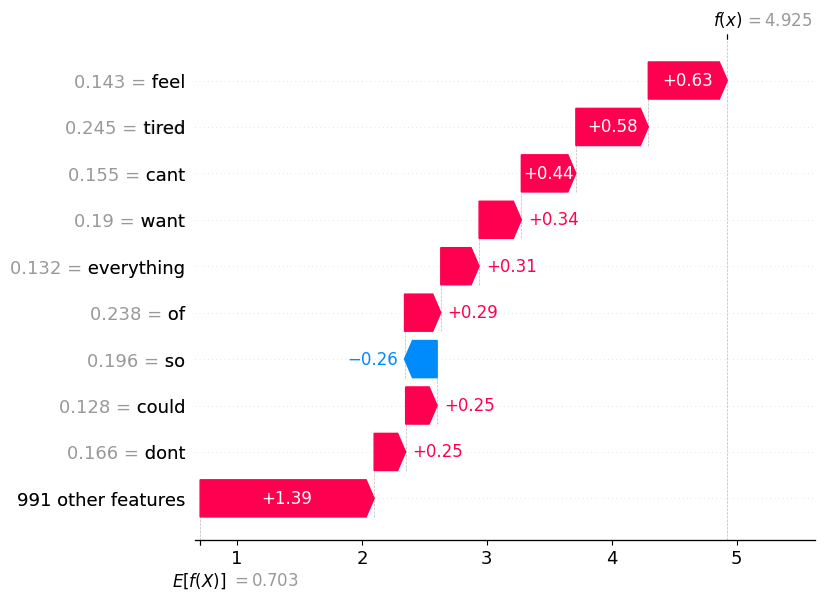

In [64]:
import shap

shap.initjs()

ind = 6
print(X_test[ind])

# For binary classification, no need for the last axis
shap.plots.waterfall(shap_values[ind])


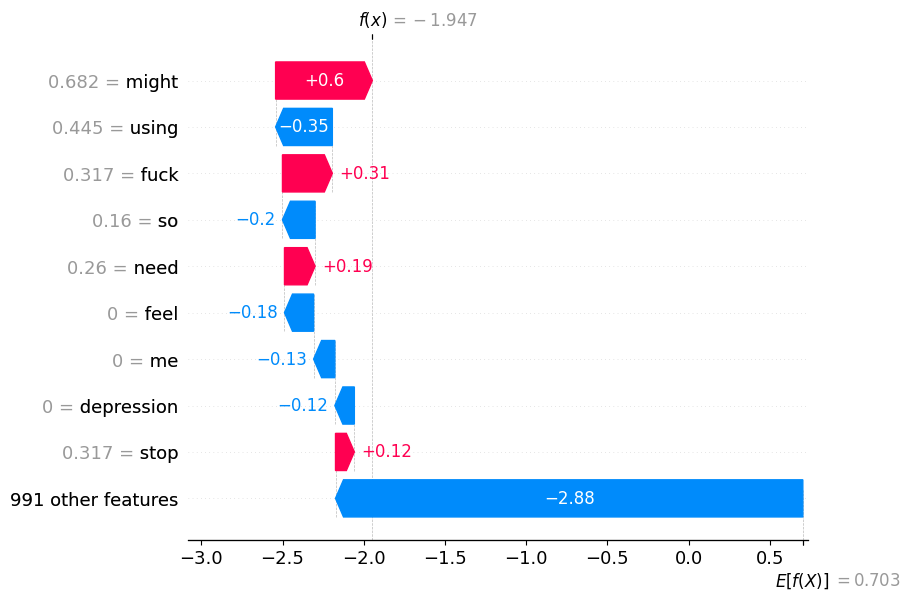

In [65]:
# Explain the first prediction
shap.plots.waterfall(shap_values[0])

In [66]:
# Visualize the first prediction's explanation
shap.plots.force(shap_values[0])

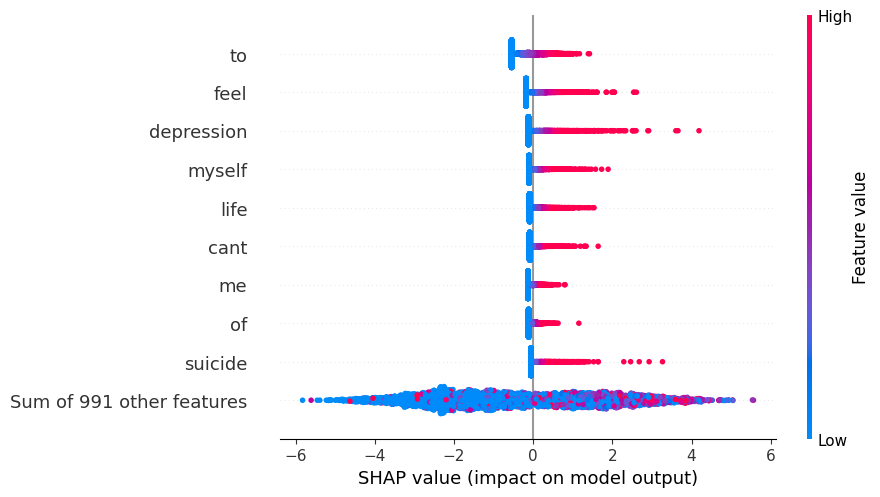

In [67]:
# Create a summary plot to see the most important features
shap.plots.beeswarm(shap_values)

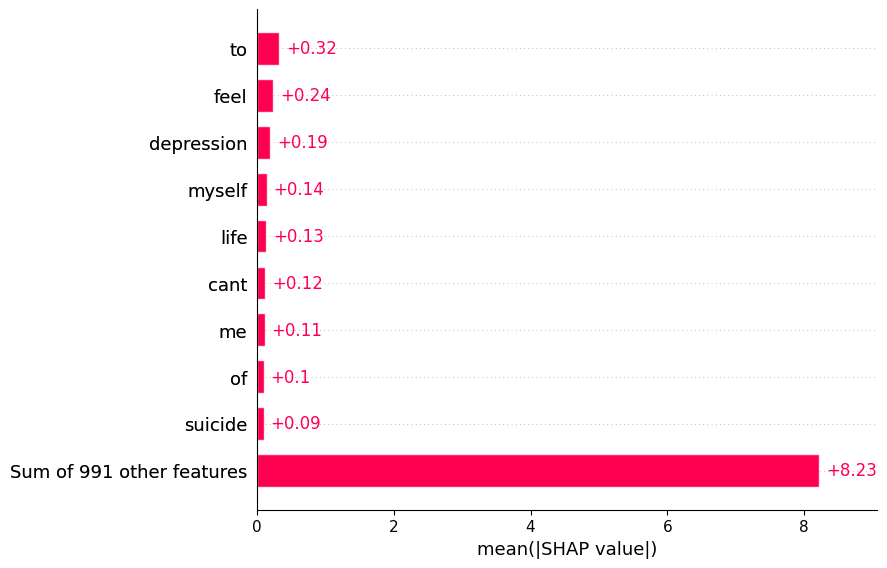

In [68]:
# Create a bar plot of global feature importances
shap.plots.bar(shap_values)

Original SHAP values shape: (4000, 1000)
Shape after selecting the only class: (4000, 1000)
Generating Beeswarm plot...


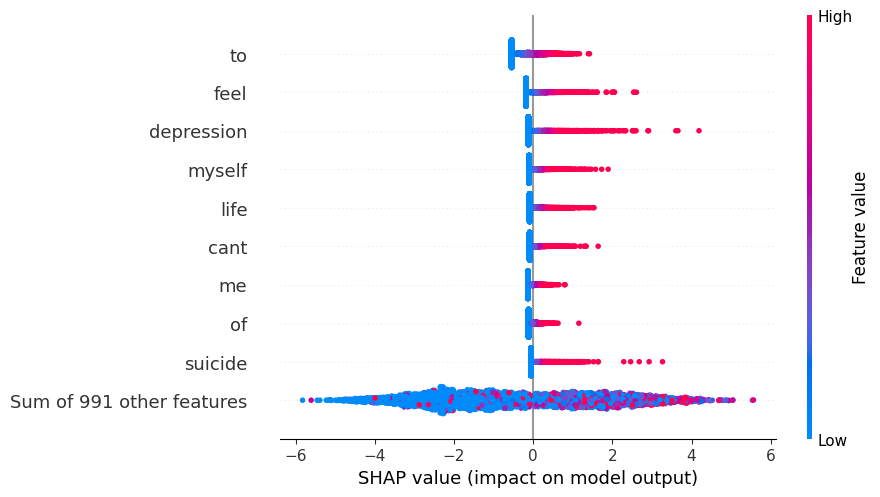


Generating Bar plot...


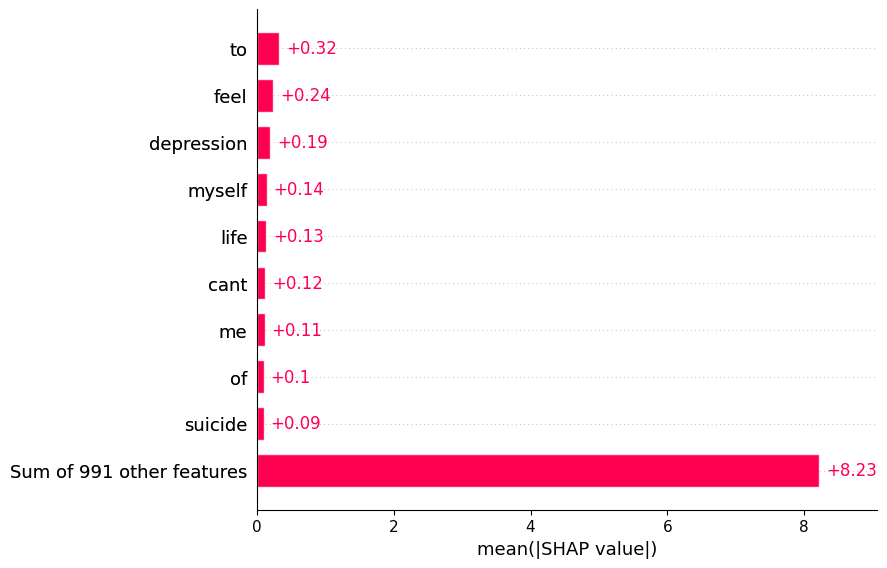


Generating Dependence plot for feature 'depression'...


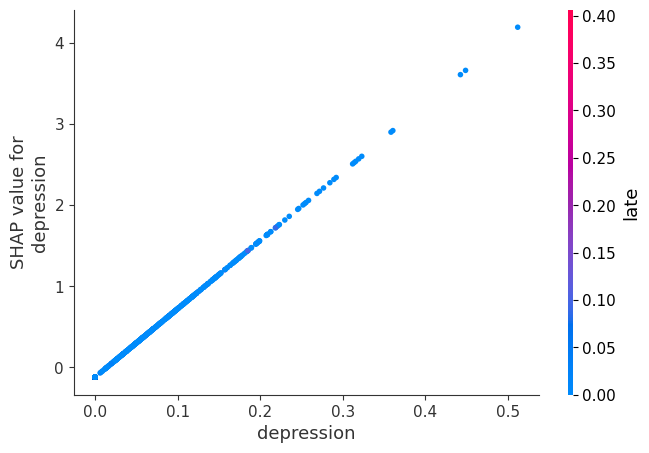

In [76]:
# Check the shape, it should be something like (num_samples, num_features, 1)
print(f"Original SHAP values shape: {shap_values.shape}")

# Select the SHAP values for the ONLY output class (at index 0)
# This will result in a 2D array, which the plots expect.
shap_values_for_plotting = shap_values[:, :, 0]

print(f"Shape after selecting the only class: {shap_values_for_plotting.shape}")

# Beeswarm plot for the model's output
print("Generating Beeswarm plot...")
shap.plots.beeswarm(shap_values_for_plotting)

# Bar plot for the model's output
print("\nGenerating Bar plot...")
shap.plots.bar(shap_values_for_plotting)

# Dependence plot for the model's output
# Ensure X_test_tfidf is a dense array for plotting
if "sparse" in str(type(X_test_tfidf)):
    X_test_dense = X_test_tfidf.toarray()
else:
    X_test_dense = X_test_tfidf

feature_to_plot = 'depression' # Make sure this word is in your feature_names

print(f"\nGenerating Dependence plot for feature '{feature_to_plot}'...")
shap.dependence_plot(
    feature_to_plot,
    shap_values_for_plotting.values,
    X_test_dense,
    feature_names=feature_names
)